In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
#from iexfinance.stocks import get_historical_data
#import iexfinance as iex
#from iexfinance.stocks import get_historical_data
#from iexfinance.refdata import get_symbols

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
#IEX_TOKEN = os.getenv('IEX_TOKEN')


#type(IEX_TOKEN)

str

              TSLA    MSFT
             close   close
date                      
2019-01-29  297.46  102.94
2019-01-30  308.77  106.38
2019-01-31  307.02  104.43
2019-02-01  312.21  102.78
2019-02-04  312.89  105.74


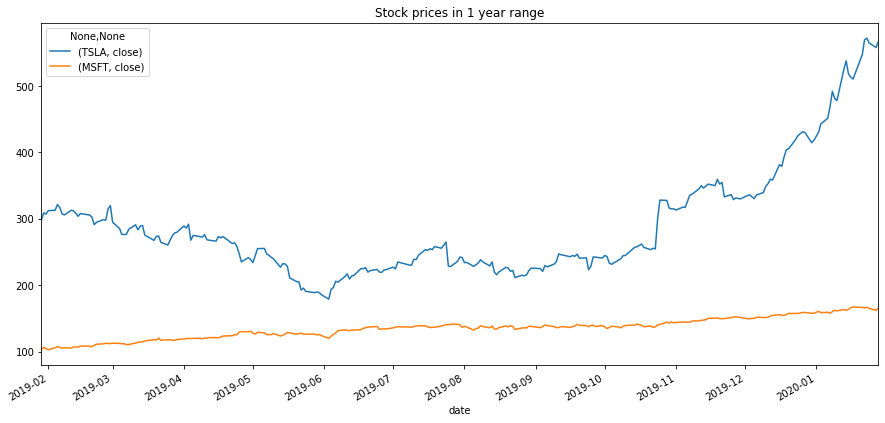

In [7]:
list_of_tickers = ["TSLA", "MSFT"]
# YOUR CODE HERE
end_date = datetime.now()
start_date = end_date + timedelta(-365)

#get one year historical data for 'TSLA' and 'MSFT'
#portfolio_df = get_historical_data(list_of_tickers, start_date, end_date, close_only=True,  output_format='pandas').astype(float)
#portfolio_df.drop(columns='volume',level=1,inplace=True)
#portfolio_df = portfolio_df.to_pickle('HISTORIC_TSLA_MSFT_GE')
portfolio_df = pd.read_pickle('HISTORIC_TSLA_MSFT_GE')

portfolio_df.plot(title="Stock prices in 1 year range", figsize=(15,7))

print(portfolio_df.head())



# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [8]:
# Calculate the daily roi for the stocks
# YOUR CODE HERE
daily_roi = portfolio_df.pct_change().dropna()
daily_roi.tail()

,TSLA,MSFT
,close,close
date,,
2020-01-22,0.040863,-0.004805
2020-01-23,0.004635,0.006156
2020-01-24,-0.012898,-0.010077
2020-01-27,-0.012039,-0.016723
2020-01-28,0.015913,0.019596


In [9]:
#calculate value of average daily roi as it is neccessary for roi simulation
avg_daily_roi_TSLA = daily_roi.mean()['TSLA']['close']
avg_daily_roi_MSFT = daily_roi.mean()['MSFT']['close']

print(f"The level of daily return for TSLA = {avg_daily_roi_TSLA}")
print(f"The level of daily return for MSFT = {avg_daily_roi_MSFT}")

The level of daily return for TSLA = 0.0030328083901825344
The level of daily return for MSFT = 0.00196296986396302


In [12]:
# Calculate volatility
# YOUR CODE HERE
std_daily_roi_TSLA = daily_roi.std()['TSLA']['close']
std_daily_roi_MSFT = daily_roi.std()['MSFT']['close']

print(f"The level of daily standard deviation for TSLA = {std_daily_roi_TSLA}")
print(f"The level of daily standard deviation for MSFT = {std_daily_roi_MSFT}")

The level of daily standard deviation for TSLA = 0.030484083824331643
The level of daily standard deviation for MSFT = 0.011885924753681876


In [14]:
# Save the last day's closing price for 'TSLA' and 'MSFT'
# YOUR CODE HERE

last_price_TSLA = portfolio_df['TSLA']['close'][-1]
last_price_MSFT = portfolio_df['MSFT']['close'][-1]

#print the last day closing price
print(f"Last closing price for TSLA is ${last_price_TSLA}!")
print(f"Last closing price for MSFT is ${last_price_MSFT}!")

Last closing price for TSLA is $566.9!
Last closing price for MSFT is $165.46!


In [39]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 3

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Initialize empty DataFrame to hold simulated prices for Monte Carlo simulation
monte_carlo = pd.DataFrame()


In [40]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    #Initialize the simulated prices list with the last closing price 
    simulated_prices_TSLA = [last_price_TSLA]
    simulated_prices_MSFT = [last_price_MSFT]
    
    #ROI simulation for 30 years * 252 trading days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_price_TSLA = simulated_prices_TSLA[-1] * (1 + np.random.normal(avg_daily_roi_TSLA, std_daily_roi_TSLA))
        simulated_price_MSFT = simulated_prices_MSFT[-1] * (1 + np.random.normal(avg_daily_roi_MSFT, std_daily_roi_MSFT))
            
        # Append the simulated price to the list
        simulated_prices_TSLA.append(simulated_price_TSLA)
        simulated_prices_MSFT.append(simulated_price_MSFT)
        
        # Append a simulated prices of each simulation to DataFrame
    simulated_price_df["TSLA Prices"] = pd.Series(simulated_prices_TSLA)
    simulated_price_df["MSFT Prices"] = pd.Series(simulated_prices_MSFT)
        
        # Calculate the daily returns of simulated prices
    simulated_roi_daily = simulated_price_df.pct_change()
    simulated_roi_daily["TSLA Prices"] = simulated_price_df["TSLA Prices"].pct_change()
    simulated_roi_daily["MSFT Prices"] = simulated_price_df["MSFT Prices"].pct_change()
        # Set the portfolio weights (60% TSLA; 40% MSFT)
    weight_TSLA = [0.20]
    weight_MSFT = [0.80]
        
        # With the weights to multiply weights with each column's simulated daily returns

    
    weighted_portfolio_roi_daily = weight_TSLA * simulated_roi_daily["TSLA Prices"] + weight_MSFT * simulated_roi_daily["MSFT Prices"]
    
        # Calculate the normalized, cumulative return series
    monte_carlo[x] = (1 + weighted_portfolio_roi_daily.fillna(0)).cumprod()
        
        # Print records from the DataFrame
        
monte_carlo.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005329,1.005293,0.995995,1.006696,1.002084,0.986969,1.005932,1.006697,1.008549,0.992147,...,1.004159,1.006920,1.007904,1.000379,1.004315,0.991261,1.000040,1.009462,1.008330,0.994529
2,1.002141,1.010424,0.995277,0.996792,0.998589,1.005867,0.990472,0.993591,1.012010,0.991707,...,1.023747,1.017499,1.007956,1.015392,0.985528,0.978526,0.994061,1.038073,0.992746,1.005091
3,1.004444,1.004650,0.984974,1.014126,1.002147,1.017406,0.981855,1.002263,1.004312,0.992823,...,1.044596,1.008720,0.996211,1.028935,0.983246,0.992608,1.006067,1.029109,0.984211,1.014202
4,1.013251,1.008995,0.989592,1.032529,1.001359,1.031232,0.968202,1.007703,0.992038,1.025279,...,1.030419,1.005512,1.006816,1.021146,0.966976,0.979983,1.020380,1.041408,0.973668,0.993088


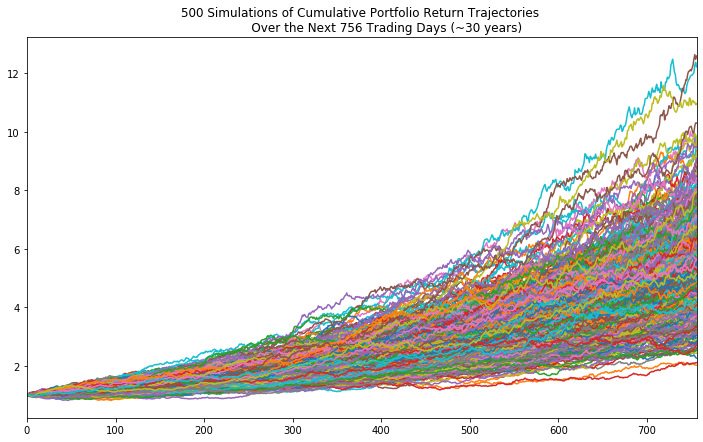

In [41]:
# Visualize the Simulation
# YOUR CODE HERE
plot_title = f"{number_simulations} Simulations of Cumulative Portfolio Return Trajectories \n \
            Over the Next {number_records} Trading Days (~30 years)"
monte_carlo.plot(legend=None, title=plot_title, figsize=(12,7))

In [42]:
#simulated prices
round(simulated_price_df.tail(), 2)

,TSLA Prices,MSFT Prices
752,1825.83,634.04
753,1809.23,634.76
754,1746.36,631.01
755,1767.23,643.41
756,1688.91,635.59


In [43]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
# YOUR CODE HERE
ending_roi_cumulative = monte_carlo.iloc[-1, :]
round(ending_roi_cumulative.tail(),2)

495    4.08
496    5.60
497    3.50
498    5.15
499    3.90
Name: 756, dtype: float64

In [44]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
# YOUR CODE HERE
round(ending_roi_cumulative.tail(1), 2)

499    3.9
Name: 756, dtype: float64

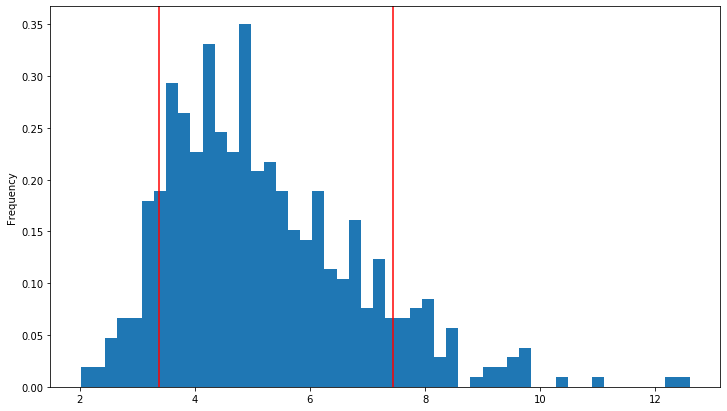

In [45]:
# Display the 90% confidence interval for the ending returns
# YOUR CODE HERE

conf_interval = ending_roi_cumulative.quantile(q=[0.1, 0.9])
conf_interval

#`plot` function to create a probability distribution histogram of simulated ending prices

plt.figure();
ending_roi_cumulative.plot(kind='hist', density=True, bins=50,figsize=(12,7))
plt.axvline(conf_interval.iloc[0], color='r')
plt.axvline(conf_interval.iloc[1], color='r')

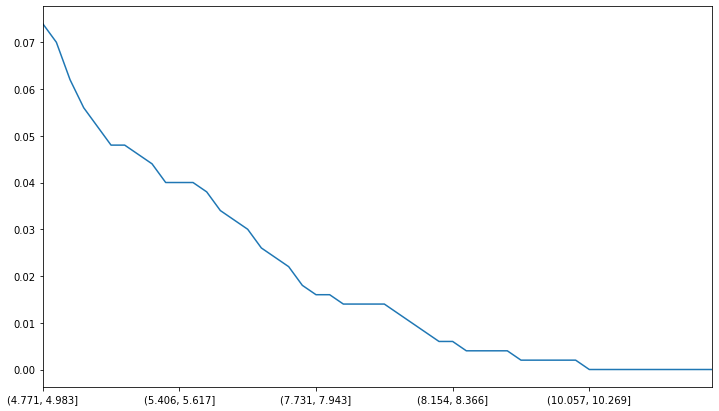

In [46]:
# Visualize the distribution of the ending returns
# YOUR CODE HERE

ending_roi_prob_distribution = ending_roi_cumulative.value_counts(bins=50) / len(ending_roi_cumulative)
ending_roi_prob_distribution.plot(figsize=(12,7))

---

#### Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$50,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [48]:
# YOUR CODE HERE
initial_investment = 50_000

new_conf_interval = ending_roi_cumulative.quantile(q=[0.1,0.5,0.9])
round(new_conf_interval, 2)

0.1    3.38
0.5    4.88
0.9    7.44
Name: 756, dtype: float64

In [49]:
expected_roi_10th_per = new_conf_interval.iloc[0]
expected_roi_50th_per = new_conf_interval.iloc[1]
expected_roi_90th_per = new_conf_interval.iloc[2]

print(f"""
Expected cumulative percentage returns at 30 years:
        10th percent {expected_roi_10th_per:,.2f} %
        50th percent {expected_roi_50th_per:,.2f} %
        90th percent {expected_roi_90th_per:,.2f} %""")


Expected cumulative percentage returns at 30 years:
        10th percent 3.38 %
        50th percent 4.88 %
        90th percent 7.44 %


### Given an initial investment of `$50,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [50]:
# YOUR CODE HERE
expected_roi_10th_usd = initial_investment * new_conf_interval.iloc[0]
expected_roi_50th_usd = initial_investment * new_conf_interval.iloc[1]
expected_roi_90th_usd = initial_investment * new_conf_interval.iloc[2]

print(f"""
Expected cumulative returns at 3 years:
        10th perc ${expected_roi_10th_usd:,.2f}
        50th perc ${expected_roi_50th_usd:,.2f}
        90th perc ${expected_roi_90th_usd:,.2f}""")


Expected cumulative returns at 30 years:
        10th perc $169,115.80
        50th perc $243,761.87
        90th perc $372,042.03


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [51]:
# YOUR CODE HERE
#gross income from Plaid analysis
prev_year_gross_income = 6_000
# withdrawall rate of 4% 
yearly_withdraw_rate = 0.04

expected_yearly_withdrawal = expected_roi_10th_usd * yearly_withdraw_rate

if (expected_yearly_withdrawal > prev_year_gross_income):
    print(f"Yearly withdrawal rate of 4% is equal to ${expected_yearly_withdrawal:,.2f} and it is higher than previous year's gross income of ${prev_year_gross_income:,.2f}.")
else:
    print(f"Yearly withdrawal rate of 4%is equal to  ${expected_yearly_withdrawal:,.2f}and it is lower than previous year's gross income ${prev_year_gross_income:,.2f}.")

Yearly withdrawal rate of 4% is equal to $6,764.63 and it is higher than previous year's gross income of $6,000.00.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [52]:
# YOUR CODE HERE
#50% increase in initial investment
invest_increase = 0.50
#initial_investment_2 = initial_investment * (1 + invest_increase)
#effect of increase in initial investment 

expected_yearly_withdrawal = expected_roi_10th_usd * yearly_withdraw_rate
#New expected returns for 10th percentile in USD

new_expected_roi_10th_usd = (initial_investment * (1 + invest_increase)) * new_conf_interval.iloc[0]

new_expected_yearly_withdrawal =  new_expected_roi_10th_usd * yearly_withdraw_rate
# printint the effect of higher initial investment

if (new_expected_yearly_withdrawal > expected_yearly_withdrawal):
    print(f"Initial investment increase by 50% results with higher 4% retirement withdrawall for ${new_expected_yearly_withdrawal - expected_yearly_withdrawal:,.2f}!!!")
else:
    print(f"Initial investment increase by 50% results with lower 4% retirement withdrawall for ${new_expected_yearly_withdrawal - expected_yearly_withdrawal:,.2f}")

Initial investment increase by 50% results with higher 4% retirement withdrawall for $3,382.32!!!
